In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.0'

In [42]:
import csv
import numpy as np
from sklearn.preprocessing import LabelBinarizer

csvFile = '/Users/aleksey/Main/MachineLearning/moving-classification/gyroscope_data.csv'
numberOfMeasurementsPerSample = 50


csvFileReader = csv.reader(open(csvFile), delimiter=',')
linesWithoutHeader = ([x for x in csvFileReader])[1:]

def removeLastColumn(lines):
    return [line[:-1] for line in lines]

def prepareDictionaryWithLabelsToSortedMeasurements(lines):
    def filterLinesWithLabel(label, lines):
        return [line for line in lines if line[-1] == label]

    def sortByTime(lines):
        return sorted(lines, key=lambda line: line[-2], reverse=False)
    
    def findUniqLabes(lines):
        return set([line[-1] for line in lines])
    
    labesToFeatures = {}
    
    for label in findUniqLabes(lines):
        labesToFeatures[label] = removeLastColumn(filterLinesWithLabel(label, lines))
    
    return labesToFeatures

labelsToMeasurements = prepareDictionaryWithLabelsToSortedMeasurements(linesWithoutHeader)                                                   

def prepareData(labelsToMeasurements, numberOfMeasurementsPerSample):
    def createSamplesForLabel(label, measurements, numberOfMeasurementsPerSample):
        numberOfSamples = len(measurements) // numberOfMeasurementsPerSample
        
        samples = np.zeros((numberOfSamples, numberOfMeasurementsPerSample, len(measurements[0])))
        
        for i in range(0, numberOfSamples):
            measurementsPerSample = measurements[i * numberOfMeasurementsPerSample : (i + 1) * numberOfMeasurementsPerSample]
            samples[i] = np.array(measurementsPerSample)
        return samples
    
    samples = []
    targets = []
    
    for label, measurements in labelsToMeasurements.items():
        samplesOfLabel = createSamplesForLabel(label, measurements, numberOfMeasurementsPerSample)
        
        samples.extend(samplesOfLabel)
        targets.extend(np.full((samplesOfLabel.shape[0]), label))
    
    return np.array(samples), np.array(targets)

def shuffleSamplesAndTargets(samples, targets):
    randomize = np.arange(samples.shape[0])
    np.random.shuffle(randomize)
    samples = samples[randomize]
    targets = targets[randomize]
    
    return samples, targets

samples, targets = prepareData(labelsToMeasurements, numberOfMeasurementsPerSample)
samples, targets = shuffleSamplesAndTargets(samples, targets)
targets = LabelBinarizer().fit_transform(targets)

print(samples.shape)
print(targets.shape)

(1260, 50, 6)
(1260, 3)


In [43]:
train_part_in_percents = 0.6
val_part_in_percents = 0.2
test_part_in_percents = 0.2

train_part_end = int(train_part_in_percents * samples.shape[0])
val_part_end = train_part_end + int(val_part_in_percents * samples.shape[0])
test_part_end = val_part_end + int(test_part_in_percents * samples.shape[0])

train_data = samples[0:train_part_end]
train_labels = targets[0:train_part_end]
print(train_data.shape)
print(train_labels.shape)

val_data = samples[train_part_end:val_part_end]
val_labels = targets[train_part_end:val_part_end]
print(val_data.shape)
print(val_labels.shape)

test_data = samples[val_part_end:test_part_end]
test_labels = targets[val_part_end:test_part_end]
print(test_data.shape)
print(test_labels.shape)

(756, 50, 6)
(756, 3)
(252, 50, 6)
(252, 3)
(252, 50, 6)
(252, 3)


In [44]:
val_labels

array([[0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0,

In [45]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Conv1D(32, 3, activation='relu',
                        input_shape=(None, train_data.shape[-1])))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(32, 3, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(3, activation='softmax'))

In [46]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='mse',
              metrics=['accuracy'])

In [47]:
history = model.fit(train_data,
                    train_labels,
                    epochs=100,
                    batch_size=64,
                    validation_data=(val_data, val_labels))

Train on 756 samples, validate on 252 samples
Epoch 1/100
756/756 [==============================] - 2s 2ms/step - loss: 0.1995 - acc: 0.5622 - val_loss: 0.1640 - val_acc: 0.6508
Epoch 2/100
756/756 [==============================] - 0s 449us/step - loss: 0.1584 - acc: 0.6733 - val_loss: 0.1478 - val_acc: 0.6865
Epoch 3/100
756/756 [==============================] - 0s 460us/step - loss: 0.1378 - acc: 0.7011 - val_loss: 0.1367 - val_acc: 0.7143
Epoch 4/100
756/756 [==============================] - 0s 455us/step - loss: 0.1274 - acc: 0.7315 - val_loss: 0.1352 - val_acc: 0.6944
Epoch 5/100
756/756 [==============================] - 0s 466us/step - loss: 0.1219 - acc: 0.7460 - val_loss: 0.1255 - val_acc: 0.7659
Epoch 6/100
756/756 [==============================] - 0s 462us/step - loss: 0.1130 - acc: 0.7606 - val_loss: 0.1202 - val_acc: 0.7540
Epoch 7/100
756/756 [==============================] - 0s 474us/step - loss: 0.1110 - acc: 0.7672 - val_loss: 0.1166 - val_acc: 0.7341
Epoch 8/100

Epoch 61/100
756/756 [==============================] - 0s 515us/step - loss: 0.0226 - acc: 0.9643 - val_loss: 0.0381 - val_acc: 0.9286
Epoch 62/100
756/756 [==============================] - 0s 538us/step - loss: 0.0277 - acc: 0.9471 - val_loss: 0.0419 - val_acc: 0.9286
Epoch 63/100
756/756 [==============================] - 0s 496us/step - loss: 0.0215 - acc: 0.9669 - val_loss: 0.0427 - val_acc: 0.9246
Epoch 64/100
756/756 [==============================] - 0s 523us/step - loss: 0.0213 - acc: 0.9669 - val_loss: 0.0505 - val_acc: 0.9087
Epoch 65/100
756/756 [==============================] - 0s 502us/step - loss: 0.0184 - acc: 0.9722 - val_loss: 0.0425 - val_acc: 0.9246
Epoch 66/100
756/756 [==============================] - 0s 507us/step - loss: 0.0177 - acc: 0.9709 - val_loss: 0.0388 - val_acc: 0.9325
Epoch 67/100
756/756 [==============================] - 0s 533us/step - loss: 0.0192 - acc: 0.9656 - val_loss: 0.0388 - val_acc: 0.9246
Epoch 68/100
756/756 [==========================

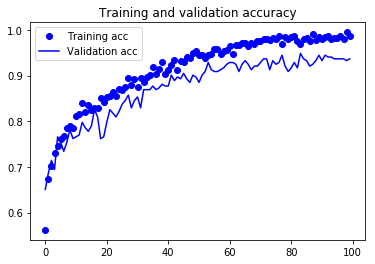

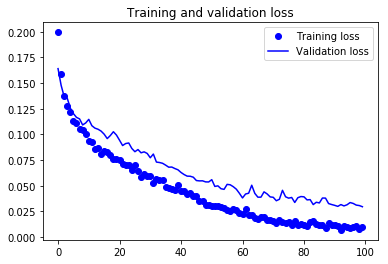

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [49]:
model.evaluate(test_data, test_labels)

252/252 [==============================] - 0s 151us/step


[0.023892943229940202, 0.9563492082414173]

In [41]:
model.predict(test_data[0:1])

array([[7.00606397e-05, 1.34642905e-04, 9.99795258e-01],
       [9.81218994e-01, 1.83361676e-02, 4.44828940e-04],
       [3.87563399e-04, 9.99606907e-01, 5.65813161e-06],
       [2.91918102e-03, 9.94645000e-01, 2.43583578e-03],
       [9.96336341e-01, 3.52772512e-03, 1.35844850e-04],
       [6.04871602e-05, 1.08272914e-04, 9.99831200e-01],
       [1.89741678e-03, 4.16812720e-04, 9.97685790e-01],
       [8.13019797e-05, 1.52951031e-06, 9.99917150e-01],
       [1.23729359e-03, 9.98760581e-01, 2.14127704e-06],
       [6.66096015e-03, 3.17710394e-04, 9.93021309e-01]], dtype=float32)